# Distill Example

### License

In [ ]:
#
# Copyright 2022 The Applied Research Laboratory for Intelligence and Security (ARLIS)
#
# Licensed to the Apache Software Foundation (ASF) under one or more
# contributor license agreements.  See the NOTICE file distributed with
# this work for additional information regarding copyright ownership.
# The ASF licenses this file to You under the Apache License, Version 2.0
# (the "License"); you may not use this file except in compliance with
# the License.  You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

### Imports Used in this Example

In [1]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import connections
from elasticsearch_dsl import Search
from elasticsearch_dsl import Q
from elasticsearch_dsl.query import MultiMatch, Match
from collections import Counter, deque
from itertools import count
from uuid import uuid4

import distill
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import json
import itertools
import networkx as nx
import hashlib, base64
import plotly.graph_objects as go

## Define Search into Logging Database

Using Elasticsearch as a backend, we can create new connection to a test instance and define a search object based on that instance and a specific index to search.

In [2]:
flagonClient = connections.create_connection('flagonTest', hosts=['localhost:9200'], timeout=60)

#TODO describeabs connections

#hello world test
print(flagonClient)

<Elasticsearch([{'host': 'localhost', 'port': 9200}])>


In [3]:
AleS = Search(using='flagonTest', index="userale")

## Define Queries against Log Data

### Simple Queries

In [4]:
qLogType = Q("match", logType="raw") | Q("match", logType="custom")
print(qLogType)

Bool(should=[Match(logType='raw'), Match(logType='custom')])


In [5]:
qUserId = Q("match", userId="superset-user")
print(qUserId)

Match(userId='superset-user')


In [6]:
qExcludeSession = Q("match", sessionID="") & Q("match", sessionID="")
print(qExcludeSession)

Bool(must=[Match(sessionID=''), Match(sessionID='')])


### Not-As-Simple Queries

In [7]:
qUrl = Q({"wildcard": {
    "pageUrl": {
        "value": "*/superset/dashboard*"
    }
}})
print(qUrl)

Wildcard(pageUrl={'value': '*/superset/dashboard*'})


### Define Filters

In [9]:
filterEvents = Q('bool', filter=[~Q('terms', type=['keydown', 'mousedown', 'mouseup'])])
print(filterEvents)

Bool(filter=[Bool(must_not=[Terms(type=['keydown', 'mousedown', 'mouseup'])])])


## Chained Searches

In [10]:
elk_search = AleS \
    .query(qUrl) \
    .query(qLogType) \
    .query(qUserId) \
    .query(filterEvents) \
    .extra(track_total_hits=True) #breaks return limit of 10000 hits

NOTE: `.execute()` will only retreive the first 10 hits with additional terms embedded in queries. Use `.scan()` instead if you want to retreive all the hits. We use `.execute()` below for brevity.

In [11]:
ale_dict = {}
elk_response = elk_search.scan()
for hit in elk_response:
    logEntry = (hit.to_dict())
    logEntry['uid'] = distill.getUUID(logEntry)
    logEntry['clientTime'] = distill.epoch_to_datetime(logEntry['clientTime'])
    ctr = len(ale_dict)
    ctr += 1
    ale_dict[ctr] = logEntry

print(len(ale_dict))

12301


## Data Forensics
Data Forensics refers to ascertaining what is in our data. We may decide that we filtered to much or too little, and want to re-run our scan through ELK. Or, we may decide just how to apply filters as we go and "carve" out new dictionaries with less data, but more of the data we want. The following examples illustrate how to work with UserALE data in a dictionary format to perform data forensics.

### Sorting
Getting User logs into a logical sequence can aid in a number of operations down the line.

A simple lambda function helps in sorting our user log dict by `clientTime` (when logs were written by the client).

In [12]:
sorted_data = dict(sorted(ale_dict.items(), key = lambda kv: kv[1]['clientTime']))
len(sorted_data)

12301

### Searching
Before we can filter out what we don't want in our data, we have to be able to be able to describe what we do and don't want.  Dictionaries are a fast and efficient way to search through data and Distill provides some supporting libraries for finding the information you want from your user logs.

Distill's `find_meta_values` function uses list comprehensions to quickly provide all the unique values for specific key (e.g., `sessionID`, `userId`).

In [13]:
sessions = distill.find_meta_values('sessionID', sorted_data)
sessions

['session_1642013755036',
 'session_1642561069785',
 'session_1642012917325',
 'session_1641584276813',
 'session_1640200820004',
 'session_1642626473013',
 'session_1641502434428',
 'session_1640029398947',
 'session_1642562635205',
 'session_1640118177195',
 'session_1641844965430',
 'session_1642004982781']

In [14]:
users = distill.find_meta_values('userId', sorted_data)
users 

['superset-user']

Relying on the dictionary format, we can quickly create new dictionaries with certain characteristics using simple dictionary comprehensions (e.g., a dictionary with all logs that contain the key: `path`; a dictionarey with all logs where `type`== `click`).

In [15]:
values = ['path']
sorted_data_paths = {k:v for k, v in sorted_data.items() if any(item in values for item in v.keys())}
len(sorted_data_paths)

12298

In [16]:
values = ['click']
sorted_data_paths_clicks = {k:v for k, v in sorted_data_paths.items() if any(item in values for item in v.values())}
len(sorted_data_paths_clicks)

392

Using the same methods, we can find all logs that refer to a specific DOM element in the field `path`. 

In [17]:
ele = ['div.superset-legacy-chart-world-map']
sorted_data_pathele = {k:v for k, v in sorted_data_paths.items() if any(item in ele for item in v['path'])}
len(sorted_data_pathele.keys())

1888

In [18]:
toggleEle = ['button.ant-btn superset-button css-1mljg09', 'div#chart-id-515.filter_box']
sorted_data_pathele = {k:v for k, v in sorted_data_paths_clicks.items() if all(item in v['path'] for item in toggleEle)}
len(sorted_data_pathele.keys()) 

5

## Segmentation
User data is always nested in time--the things they do, explore, and select are bound to time. Segmentation is the practice of slicing a series of data into a set of epochs (time-bound bins of logs) defined by some characteristic. They can be very general (e.g., 30 second, non-overlapping intervals starting from the beginning of a user session), or they can be very specific (e.g., an epoch when users were interacting with a specific UI element with filters set). Segmentation is generally very challenging and in the realm of 'advanced user analytics'. Distill makes segmentation much easier by supporting data scientists in creating and curating segments as mutable object. See the examples below: 

We want to to be able to create and curate segments without having to rewrite new datasets every time. We're going to start by creating a Master Dictionary for all our interesting segments:

In [19]:
superSegments = {}
superSegments

{}

### Finding Deadspace
In one case we might want to readily identify epochs within user sessions wherein users aren't doing anything. We call this "deadspace"--a user might have started doing something else AFK, but we have no user behavior to indicate they've switch tasks (e.g., `blur` event). Deadspace can be useful to identify; we can omit it from other segments if we need to. Distill's `detect_deadspace` function is helpful for finding deadspace:

In [20]:
deadSpaceSegments = distill.detect_deadspace(sorted_data_paths, 60, 0, 0)
for counter, d in enumerate(deadSpaceSegments.values(), start=1):
    d.segment_name = str("deadSpace" + str(counter)) #renaming segment names on the fly
    d.segment_length_sec = (d.start_end_val[1] - d.start_end_val[0])/1000 #adding custom segment-object attributes
    print(d.segment_name, d.segment_type, d.start_end_val, d.segment_length_sec, d.num_logs, d.uids)

deadSpace1 Segment_Type.DEADSPACE (1640029869288, 1640030063271) 193.983 4 [350, 301, 346, 347]
deadSpace2 Segment_Type.DEADSPACE (1640030219069, 1640098958897) 68739.828 2 [840, 924]
deadSpace3 Segment_Type.DEADSPACE (1640098969598, 1640099715182) 745.584 2 [991, 990]
deadSpace4 Segment_Type.DEADSPACE (1640099716927, 1640118186776) 18469.849 3 [1007, 674, 1126]
deadSpace5 Segment_Type.DEADSPACE (1640118296632, 1640182567282) 64270.65 6 [782, 981, 1121, 1222, 1227, 1241]
deadSpace6 Segment_Type.DEADSPACE (1640182573419, 1640201030250) 18456.831 3 [1231, 1426, 1589]
deadSpace7 Segment_Type.DEADSPACE (1640201075969, 1640201157009) 81.04 2 [1651, 1819]
deadSpace8 Segment_Type.DEADSPACE (1640201172007, 1640201332691) 160.684 2 [1812, 1869]
deadSpace9 Segment_Type.DEADSPACE (1640201346787, 1640201425011) 78.224 4 [1974, 2102, 2118, 2127]
deadSpace10 Segment_Type.DEADSPACE (1640201494535, 1640201568436) 73.901 4 [2183, 2184, 2185, 2186]
deadSpace11 Segment_Type.DEADSPACE (1640201578551, 1640

Distill is designed to supplement forensic workflows. We might learn that segmenting one way doesn't work. We can easily modify parameters with review and modify quickly. In this case we may need to assume that 1 minute of 'deadspace' is normal use, we can revise our timing parameters and return a more reasonable solution:

In [21]:
deadSpaceSegments = distill.detect_deadspace(sorted_data_paths, 360, 0, 0)
for counter, d in enumerate(deadSpaceSegments.values(), start=1):
    d.segment_name = str("deadSpace" + str(counter)) #renaming segment names on the fly
    d.segment_length_sec = (d.start_end_val[1] - d.start_end_val[0])/1000 #adding custom segment-object attributes
    print(d.segment_name, d.segment_type, d.start_end_val, d.segment_length_sec, d.num_logs, d.uids)

deadSpace1 Segment_Type.DEADSPACE (1640030219069, 1640098958897) 68739.828 2 [840, 924]
deadSpace2 Segment_Type.DEADSPACE (1640098969598, 1640099715182) 745.584 2 [991, 990]
deadSpace3 Segment_Type.DEADSPACE (1640099716927, 1640118186776) 18469.849 3 [1007, 674, 1126]
deadSpace4 Segment_Type.DEADSPACE (1640118296632, 1640182567282) 64270.65 6 [782, 981, 1121, 1222, 1227, 1241]
deadSpace5 Segment_Type.DEADSPACE (1640182573419, 1640201030250) 18456.831 3 [1231, 1426, 1589]
deadSpace6 Segment_Type.DEADSPACE (1640202073587, 1641502449931) 1300376.344 3 [3040, 3049, 3061]
deadSpace7 Segment_Type.DEADSPACE (1641502510070, 1641584293776) 81783.706 3 [3018, 4019, 4020]
deadSpace8 Segment_Type.DEADSPACE (1641585467013, 1641846627837) 261160.824 3 [3582, 7240, 7242]
deadSpace9 Segment_Type.DEADSPACE (1641846637675, 1641849234850) 2597.175 2 [5053, 5054]
deadSpace10 Segment_Type.DEADSPACE (1641849676536, 1641910810485) 61133.949 2 [7238, 7263]
deadSpace11 Segment_Type.DEADSPACE (1641910811783, 16

Add the revised deadspace segments to the Master Dictionary of segments:

In [22]:
superSegments.update(deadSpaceSegments)
for d in superSegments.values():
    print(d.segment_name, d.segment_type)

deadSpace1 Segment_Type.DEADSPACE
deadSpace2 Segment_Type.DEADSPACE
deadSpace3 Segment_Type.DEADSPACE
deadSpace4 Segment_Type.DEADSPACE
deadSpace5 Segment_Type.DEADSPACE
deadSpace6 Segment_Type.DEADSPACE
deadSpace7 Segment_Type.DEADSPACE
deadSpace8 Segment_Type.DEADSPACE
deadSpace9 Segment_Type.DEADSPACE
deadSpace10 Segment_Type.DEADSPACE
deadSpace11 Segment_Type.DEADSPACE
deadSpace12 Segment_Type.DEADSPACE
deadSpace13 Segment_Type.DEADSPACE
deadSpace14 Segment_Type.DEADSPACE
deadSpace15 Segment_Type.DEADSPACE
deadSpace16 Segment_Type.DEADSPACE
deadSpace17 Segment_Type.DEADSPACE
deadSpace18 Segment_Type.DEADSPACE
deadSpace19 Segment_Type.DEADSPACE
deadSpace20 Segment_Type.DEADSPACE
deadSpace21 Segment_Type.DEADSPACE
deadSpace22 Segment_Type.DEADSPACE
deadSpace23 Segment_Type.DEADSPACE
deadSpace24 Segment_Type.DEADSPACE
deadSpace25 Segment_Type.DEADSPACE


### Simple Segments - Toggles
In another case, we might know exactly which events bound segment, e.g., a toggle feature or the application of a filter. If the corresponding element(s) are known we can search our dictionary for these events and create new segments readily with Distill's `create_segment` function. 

First, find all logs that contain the key with corresponding values that relate to those elements. Using UserALE.js data, we're looking for the "path" key, and within that set, only logs that correspond to 'click' events:

In [23]:
values = ['path']
sorted_data_paths = {k:v for k, v in sorted_data.items() if any(item in values for item in v.keys())}
len(sorted_data_paths)

12298

In [24]:
values = ['click']
sorted_data_paths_clicks = {k:v for k, v in sorted_data_paths.items() if any(item in values for item in v.values())}
len(sorted_data_paths_clicks)

392

Next, find all logs where "path" contains the elements that correspond to the exact 'toggle' element and extrac the times that indicate each time it was 'clicked'.

In [25]:
toggleEle = ['button.ant-btn superset-button css-1mljg09', 'div#chart-id-515.filter_box']
toggle_times = distill.pairwiseSeq([log['clientTime'] for log in sorted_data_paths_clicks.values() if all(item in log['path'] for item in toggleEle)])
toggle_times

[(1642561335946, 1642561421205),
 (1642561421205, 1642561581309),
 (1642561581309, 1642563313727),
 (1642563313727, 1642563487560)]

Now, we can submit these times to Distill's `create_segment` function:

In [26]:
segment_names = []
for i in range(0,len(toggle_times),1):
    segment_names.append(str("toggle" + str(i+1)))
toggleSegments = distill.create_segment(sorted_data_paths_clicks, segment_names, toggle_times)
for d in toggleSegments.values():
    d.segment_length_sec = (d.start_end_val[1] - d.start_end_val[0])/1000 #adding custom segment-object attributes
    print(d.segment_name, d.segment_type, d.start_end_val, d.segment_length_sec, d.num_logs)

toggle1 Segment_Type.CREATE (1642561335946, 1642561421205) 85.259 4
toggle2 Segment_Type.CREATE (1642561421205, 1642561581309) 160.104 14
toggle3 Segment_Type.CREATE (1642561581309, 1642563313727) 1732.418 127
toggle4 Segment_Type.CREATE (1642563313727, 1642563487560) 173.833 32


Finally, addrevised deadspace segments to the Master Dictionary of segments:

In [27]:
superSegments.update(toggleSegments)
for d in superSegments.values():
    print(d.segment_name, d.segment_type)

deadSpace1 Segment_Type.DEADSPACE
deadSpace2 Segment_Type.DEADSPACE
deadSpace3 Segment_Type.DEADSPACE
deadSpace4 Segment_Type.DEADSPACE
deadSpace5 Segment_Type.DEADSPACE
deadSpace6 Segment_Type.DEADSPACE
deadSpace7 Segment_Type.DEADSPACE
deadSpace8 Segment_Type.DEADSPACE
deadSpace9 Segment_Type.DEADSPACE
deadSpace10 Segment_Type.DEADSPACE
deadSpace11 Segment_Type.DEADSPACE
deadSpace12 Segment_Type.DEADSPACE
deadSpace13 Segment_Type.DEADSPACE
deadSpace14 Segment_Type.DEADSPACE
deadSpace15 Segment_Type.DEADSPACE
deadSpace16 Segment_Type.DEADSPACE
deadSpace17 Segment_Type.DEADSPACE
deadSpace18 Segment_Type.DEADSPACE
deadSpace19 Segment_Type.DEADSPACE
deadSpace20 Segment_Type.DEADSPACE
deadSpace21 Segment_Type.DEADSPACE
deadSpace22 Segment_Type.DEADSPACE
deadSpace23 Segment_Type.DEADSPACE
deadSpace24 Segment_Type.DEADSPACE
deadSpace25 Segment_Type.DEADSPACE
toggle1 Segment_Type.CREATE
toggle2 Segment_Type.CREATE
toggle3 Segment_Type.CREATE
toggle4 Segment_Type.CREATE


### Ambiguous Segments

In [28]:
mapSegments = distill.generate_segments(sorted_data_paths,'path',['div.superset-legacy-chart-world-map','window'],0,30)
for counter, d in enumerate(mapSegments.values(), start=1): 
    d.segment_name = str("map_" + str(counter))
    d.segment_length_sec = (d.start_end_val[1] - d.start_end_val[0])/1000 #adding custom segment-object attributes
    print(d.segment_name, d.start_end_val, d.segment_length_sec, d.num_logs)

map_1 (1640029804278, 1640029834278) 30.0 183
map_2 (1640029840106, 1640029870106) 30.0 67
map_3 (1640030065505, 1640030095505) 30.0 140
map_4 (1640030113456, 1640030143456) 30.0 84
map_5 (1640030159682, 1640030189682) 30.0 19
map_6 (1640030215637, 1640030245637) 30.0 7
map_7 (1640098960393, 1640098990393) 30.0 96
map_8 (1640099715638, 1640099745638) 30.0 14
map_9 (1640118193428, 1640118223428) 30.0 185
map_10 (1640118242304, 1640118272304) 30.0 135
map_11 (1640118276485, 1640118306485) 30.0 145
map_12 (1640182568142, 1640182598142) 30.0 5
map_13 (1640201041753, 1640201071753) 30.0 183
map_14 (1640201071761, 1640201101761) 30.0 55
map_15 (1640201157250, 1640201187250) 30.0 146
map_16 (1640201333004, 1640201363004) 30.0 116
map_17 (1640201425485, 1640201455485) 30.0 54
map_18 (1640201493781, 1640201523781) 30.0 8
map_19 (1640201571360, 1640201601360) 30.0 92
map_20 (1640201709131, 1640201739131) 30.0 107
map_21 (1640201770496, 1640201800496) 30.0 113
map_22 (1640201846176, 1640201876176

In [ ]:
superSegments.update(mapSegments)
for d in superSegments.values():
    print(d.segment_name, d.segment_type)

In [106]:
superSegments

{840: <distill.segmentation.segment.Segment at 0x21d0a94ffa0>,
 991: <distill.segmentation.segment.Segment at 0x21d0a94fb80>,
 1007: <distill.segmentation.segment.Segment at 0x21d07775220>,
 1121: <distill.segmentation.segment.Segment at 0x21d07775130>,
 1231: <distill.segmentation.segment.Segment at 0x21d077751f0>,
 3040: <distill.segmentation.segment.Segment at 0x21d07775ac0>,
 3018: <distill.segmentation.segment.Segment at 0x21d07775340>,
 3582: <distill.segmentation.segment.Segment at 0x21d0a96e310>,
 5053: <distill.segmentation.segment.Segment at 0x21d0f079190>,
 7238: <distill.segmentation.segment.Segment at 0x21d0f0791c0>,
 7262: <distill.segmentation.segment.Segment at 0x21d0f079220>,
 7281: <distill.segmentation.segment.Segment at 0x21d0f079820>,
 7287: <distill.segmentation.segment.Segment at 0x21d0f079250>,
 7747: <distill.segmentation.segment.Segment at 0x21d0f079280>,
 8147: <distill.segmentation.segment.Segment at 0x21d0f0792b0>,
 8794: <distill.segmentation.segment.Segme

In [102]:
mapSegments_list = []
mapSegment_times = []
for d in mapSegments.values():
    if d.num_logs > 50:
        mapSegments_list.append(d.segment_name)
        mapSegment_times.append(d.start_end_val)
len(mapSegment_times)

51

In [90]:
mapSegments_data = distill.write_segment(sorted_data_paths, mapSegments_list, mapSegment_times)
for d in mapSegments_data.keys():
    if len(mapSegments_data[d]) > 150:
        print(d, len(mapSegments_data[d]))

map_1 183
map_9 185
map_13 183
map_28 170
map_36 280
map_41 284
map_42 180
map_43 216
map_44 168
map_45 191
map_46 258
map_56 219
map_57 167
map_61 291
map_83 183
map_86 362


## Graphs and Stats

In [91]:
edges_map_1 = distill.pairwiseSeq(['|'.join(log['path']) for log in mapSegments_data['map_1'].values()])
edges_list_map_1 = list(edges_map_1)
edges_map_2 = distill.pairwiseSeq(['|'.join(log['path']) for log in mapSegments_data['map_9'].values()])
edges_list_map_2 = list(edges_map_2)

In [92]:
nodes_map_1 = set(['|'.join(log['path']) for log in mapSegments_data['map_1'].values()])
nodes_list_map_1 = list(nodes_map_1)
nodes_map_2 = set(['|'.join(log['path']) for log in mapSegments_data['map_9'].values()])
nodes_list_map_2 = list(nodes_map_2)

In [93]:
G_map1 = distill.createDiGraph(nodes_list_map_1, edges_list_map_1, drop_recursions = False)
G_map2 = distill.createDiGraph(nodes_list_map_2, edges_list_map_2, drop_recursions = False)

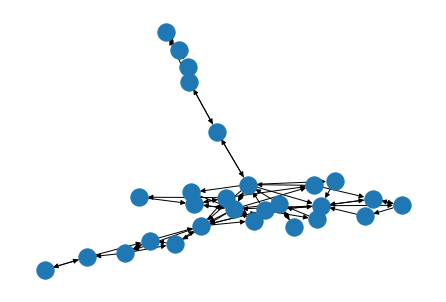

In [94]:
nx.draw(G_map1, with_labels=False)

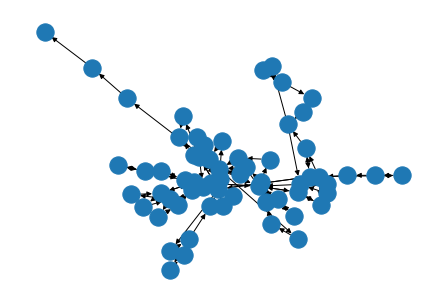

In [95]:
nx.draw(G_map2, with_labels=False)

In [96]:
nx.average_node_connectivity(G_map2)

0.9979518689196109

## Exploratory Visualization

In [101]:
distill.sankey(edges_map_1,[nodes_list_map_2[item].split("|")[0] for item in range(len(nodes_list_map_2))])

In [ ]:
distill.funnel

In [ ]:
#clickRate

In [ ]:
edge_list_temp = []
for row in edges_segmentN:
    if row[0] != row[1]: 
        edge_list_temp.append(row)
edge_list = edge_list_temp

edge_list_counter = Counter(edge_list)

source_list = [i[0] for i in edge_list_counter.keys()]
target_list = [i[1] for i in edge_list_counter.keys()]
value_list = [i for i in edge_list_counter.values()]

nodes = []
for row in edge_list:
    for col in row:
        if col not in nodes:
            nodes.append(col)           
            
sources = []
for i in source_list:
       sources.append(nodes.index(i))
targets = []
for i in target_list:
        targets.append(nodes.index(i))
values = value_list

fig = go.Figure(data=[go.Sankey(
    node = dict(
      label = [nodes[item].split("|")[0] for item in range(len(nodes))],
    ),
    link = dict(
      source = sources,
      target = targets,
      value = values
  ))])

fig.show()

# WIP

In [ ]:
x = [hashlib.md5('_'.join(log['path']).encode('utf-8')).digest() for log in finalSegments['...'].values()]
y = [hashlib.md5('_'.join(log['path']).encode('utf-8')).digest() for log in finalSegments['...'].values()]
set(x) & set (y)

In [ ]:
x = ['_'.join(log['path']) for log in finalSegments['...'].values()]
y = ['_'.join(log['path']) for log in finalSegments['...'].values()]
set(x) & set(y)

In [ ]:
nx.graph_edit_distance(G_segmentN, G_segmentN)

In [ ]:
for v in nx.optimize_graph_edit_distance(G_segmentN, G_segmentN):
    minv = v
minv

In [ ]:
dictionary[new_key] = dictionary.pop(old_key)